In [1]:
import sys
#sys.path.append("C:/Users/Surface/Documents/repos/playground")
sys.path.append("/home/peterhacker/Documents/phRepo/playground")

from Oceanmodel.policy_ve import *
from Oceanmodel.stateupdates_ve import *
from Oceanmodel.engine import *



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1460, 2, 1, 2)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 1.11s


In [2]:
# Analysis and plotting modules
import pandas as pd
# import plotly
import matplotlib.pyplot as plt

In [7]:
for agent in simulation_result[simulation_result.substep == 3].agents_oceanholder.iloc[0].keys():
    #for i in range(0,30):
    #    print(f"timestep: {simulation_result[simulation_result.substep == 3].iloc[i].timestep} | ocean_balance {simulation_result[simulation_result.substep == 3].agents_oceanholder.iloc[i][agent].oceanbalance}")

    #for acct in simulation_result[simulation_result.substep == 3].agents_oceanholder.iloc[20][agent].veaccounts.keys():
    print(agent)
    for asset in simulation_result[simulation_result.substep == 3].agents_oceanholder.iloc[600][agent].votepercent.keys():
        print(asset)
        for i in range(790,810):
            print(i)
            #if len(simulation_result[simulation_result.substep == 3].agents_oceanholder.iloc[i][agent].veaccounts.keys()) == 0:
            if len(simulation_result[simulation_result.substep == 3].agents_oceanholder.iloc[i][agent].votepercent.keys()) == 0:
                #print(f"timestep: {i} | no ve accounts")
                print(f"timestep: {i} | no votes set")
            else:
                #print(f"timestep: {simulation_result[simulation_result.substep == 3].iloc[i].timestep} | ve_locked {simulation_result[simulation_result.substep == 3].agents_oceanholder.iloc[i][agent].veaccounts[acct].locked} | ve_unlocked {simulation_result[simulation_result.substep == 3].agents_oceanholder.iloc[i][agent].veaccounts[acct].unlocked} | ve_withdrawn {simulation_result[simulation_result.substep == 3].agents_oceanholder.iloc[i][agent].veaccounts[acct].withdrawn} | ve_duration {simulation_result[simulation_result.substep == 3].agents_oceanholder.iloc[i][agent].veaccounts[acct].lockduration}")
                print(f"timestep: {simulation_result[simulation_result.substep == 3].iloc[i].timestep} | asset {asset} | vote {simulation_result[simulation_result.substep == 3].agents_oceanholder.iloc[i][agent].votepercent[asset]}")


c332a5ac-38fe-4006-b855-41a6501a6c9b
85b3f6e5-ee48-442f-a6c7-4a95baa92222
dd053e58-9340-43ce-b602-9ed00b1a780d
790
timestep: 791 | asset dd053e58-9340-43ce-b602-9ed00b1a780d | vote 0.9425932781223385
791
timestep: 792 | asset dd053e58-9340-43ce-b602-9ed00b1a780d | vote 0.9425932781223385
792
timestep: 793 | asset dd053e58-9340-43ce-b602-9ed00b1a780d | vote 0.9425932781223385
793
timestep: 794 | asset dd053e58-9340-43ce-b602-9ed00b1a780d | vote 0.9425932781223385
794
timestep: 795 | asset dd053e58-9340-43ce-b602-9ed00b1a780d | vote 0.9425932781223385
795
timestep: 796 | asset dd053e58-9340-43ce-b602-9ed00b1a780d | vote 0.9425932781223385
796
timestep: 797 | asset dd053e58-9340-43ce-b602-9ed00b1a780d | vote 0.9425932781223385
797
timestep: 798 | asset dd053e58-9340-43ce-b602-9ed00b1a780d | vote 0.9425932781223385
798
timestep: 799 | asset dd053e58-9340-43ce-b602-9ed00b1a780d | vote 0.9425932781223385
799
timestep: 800 | asset dd053e58-9340-43ce-b602-9ed00b1a780d | vote 0.9425932781223385

In [8]:
simulation_result

,agents_oceanholder,agents_data_asset,simulation,subset,run,substep,timestep
0,{'c332a5ac-38fe-4006-b855-41a6501a6c9b': ocean...,{'9963b47d-46b5-4029-ab87-fee77724086d': dataa...,0,0,1,0,0
1,{'c332a5ac-38fe-4006-b855-41a6501a6c9b': ocean...,{'9963b47d-46b5-4029-ab87-fee77724086d': dataa...,0,0,1,1,1
2,{'c332a5ac-38fe-4006-b855-41a6501a6c9b': ocean...,{'9963b47d-46b5-4029-ab87-fee77724086d': dataa...,0,0,1,2,1
3,{'c332a5ac-38fe-4006-b855-41a6501a6c9b': ocean...,{'9963b47d-46b5-4029-ab87-fee77724086d': dataa...,0,0,1,3,1
4,{'c332a5ac-38fe-4006-b855-41a6501a6c9b': ocean...,{'9963b47d-46b5-4029-ab87-fee77724086d': dataa...,0,0,1,1,2
...,...,...,...,...,...,...,...
4376,{'c332a5ac-38fe-4006-b855-41a6501a6c9b': ocean...,{'9963b47d-46b5-4029-ab87-fee77724086d': dataa...,0,0,1,2,1459
4377,{'c332a5ac-38fe-4006-b855-41a6501a6c9b': ocean...,{'9963b47d-46b5-4029-ab87-fee77724086d': dataa...,0,0,1,3,1459
4378,{'c332a5ac-38fe-4006-b855-41a6501a6c9b': ocean...,{'9963b47d-46b5-4029-ab87-fee77724086d': dataa...,0,0,1,1,1460
4379,{'c332a5ac-38fe-4006-b855-41a6501a6c9b': ocean...,{'9963b47d-46b5-4029-ab87-fee77724086d': dataa...,0,0,1,2,1460


In [9]:
# Plots for each oceanholder:
# x1. ocean balance over time
# x2. ve balance over time
# x3. ocean locked over time
# x4. ocean unlocked over time
# x5. ocean withdrawn over time
# x6. asset vote percent over time

# Plots for each ve account: SKIPPED - baked into oceanholder plots
# 1. ve balance over time
# 2. ocean locked over time
# 3. ocean unlocked over time
# 4. ocean withdrawn over time

# Plots for each data asset:
# 1. data consume volume over time
# 2. ve allocation over time
# 3. count of oceanholders voting for asset over time

Agent 7183859a-86cb-49de-8d7e-c502b657206a


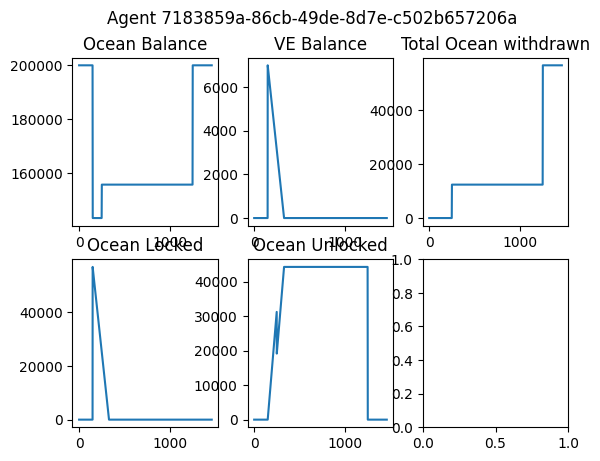

Agent 51b48e15-31c9-4519-9a44-a49a2d375d6a


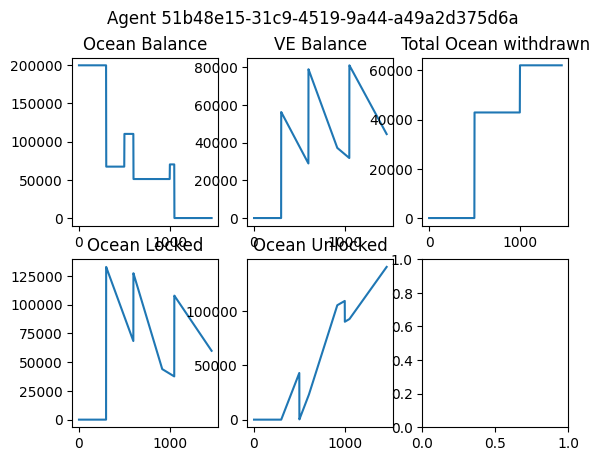

Agent c332a5ac-38fe-4006-b855-41a6501a6c9b


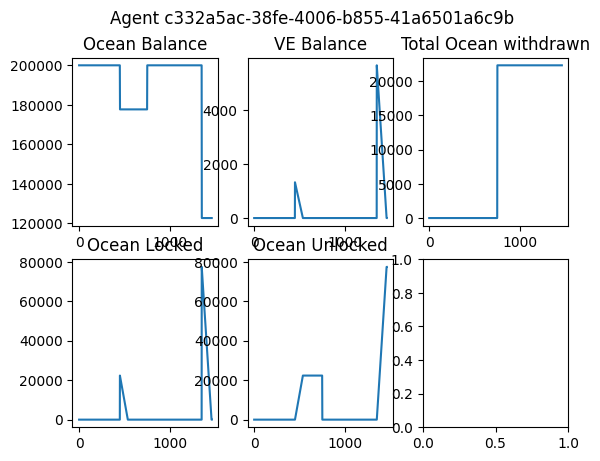

Agent 85b3f6e5-ee48-442f-a6c7-4a95baa92222


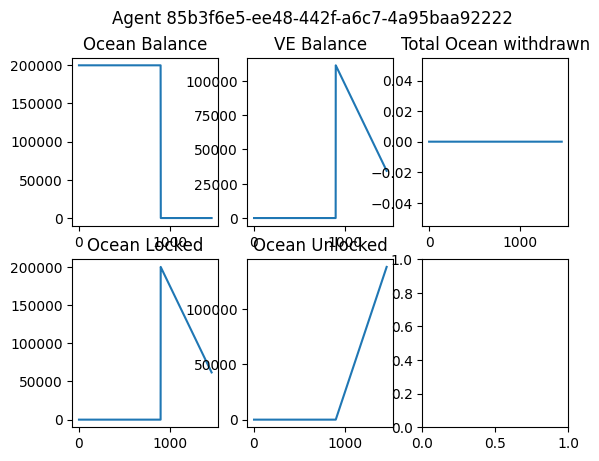

Agent 3f77fd9c-388c-4bd9-9387-d08ee3bd9421


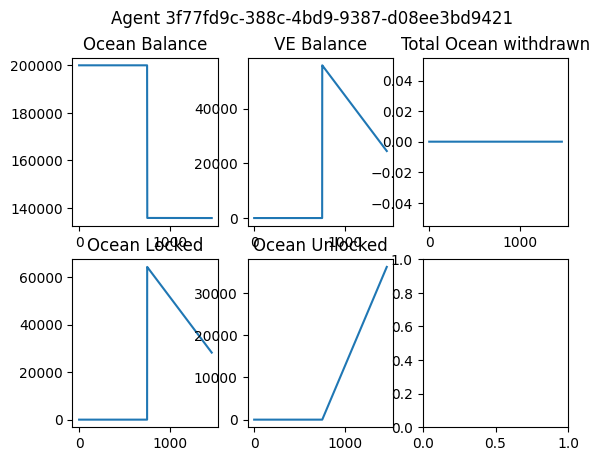

In [10]:
agents_list = []
for i in range(0,max(simulation_result.timestep)):
    agents_list.append(simulation_result.agents_oceanholder[i].keys())
agents_list = list(set([item for sublist in agents_list for item in sublist]))

# create dataframe with columns timestep, acct_id, locked, unlocked, withdrawn, ve_balance
ve_account_data = pd.DataFrame(index=range(1, max(simulation_result.timestep)+1), columns=['locked', 'unlocked', 'withdrawn', 've_balance'])

for agent in agents_list:
    print(f"Agent {agent}")
    # aggregate ve account data for agent
    for i in range(0, max(simulation_result.timestep)):
        #print(f"timestep: {i+1}")
        acct_list = simulation_result[simulation_result.substep == 3].iloc[i].agents_oceanholder[agent].veaccounts.keys()
        #print(f"ve accounts: {acct_list}")
        df_temp = pd.DataFrame()
        if len(acct_list) > 0:
            count_acct = 0
            for acct in acct_list:
                #print(f"ve account: {acct}, timestep: {i+1}, locked: {simulation_result[simulation_result.substep == 3].iloc[i].agents_oceanholder[agent].veaccounts[acct].locked}, unlocked: {simulation_result[simulation_result.substep == 3].iloc[i].agents_oceanholder[agent].veaccounts[acct].unlocked}, withdrawn: {simulation_result[simulation_result.substep == 3].iloc[i].agents_oceanholder[agent].veaccounts[acct].withdrawn}")
                # for every ve acct, we want timestep, locked, unlocked, withdrawn, ve balance
                df_temp.loc[count_acct,'timestep'] = i+1
                df_temp.loc[count_acct,'acct_id'] = acct
                df_temp.loc[count_acct,'locked'] = simulation_result[simulation_result.substep == 3].iloc[i].agents_oceanholder[agent].veaccounts[acct].locked
                df_temp.loc[count_acct,'unlocked'] = simulation_result[simulation_result.substep == 3].iloc[i].agents_oceanholder[agent].veaccounts[acct].unlocked
                df_temp.loc[count_acct,'withdrawn'] = simulation_result[simulation_result.substep == 3].iloc[i].agents_oceanholder[agent].veaccounts[acct].withdrawn
                df_temp.loc[count_acct,'ve_balance'] = simulation_result[simulation_result.substep == 3].iloc[i].agents_oceanholder[agent].veaccounts[acct].vebalance
                count_acct += 1
        else:
            df_temp.loc[0,'timestep'] = i+1
            df_temp.loc[0,'acct_id'] = None
            df_temp.loc[0,'locked'] = None
            df_temp.loc[0,'unlocked'] = None
            df_temp.loc[0,'withdrawn'] = None
            df_temp.loc[0,'ve_balance'] = None
        ve_account_data.loc[i+1, 'locked'] = df_temp['locked'].sum()
        ve_account_data.loc[i+1, 'unlocked'] = df_temp['unlocked'].sum()
        ve_account_data.loc[i+1, 'withdrawn'] = df_temp['withdrawn'].sum()
        ve_account_data.loc[i+1, 've_balance'] = df_temp['ve_balance'].sum()
    fig, axs = plt.subplots(2, 3)
    fig.suptitle(f"Agent {agent}")
    axs[0, 0].plot(simulation_result[simulation_result.substep == 3].timestep, simulation_result[simulation_result.substep == 3].agents_oceanholder.apply(lambda x: x[agent].oceanbalance))
    axs[0, 0].set_title('Ocean Balance')
    axs[0, 1].plot(simulation_result[simulation_result.substep == 3].timestep, ve_account_data.ve_balance)
    axs[0, 1].set_title('VE Balance')
    axs[1, 0].plot(simulation_result[simulation_result.substep == 3].timestep, ve_account_data.locked)
    axs[1, 0].set_title('Ocean Locked')
    axs[1, 1].plot(simulation_result[simulation_result.substep == 3].timestep, ve_account_data.unlocked)
    axs[1, 1].set_title('Ocean Unlocked')
    axs[0, 2].plot(simulation_result[simulation_result.substep == 3].timestep, ve_account_data.withdrawn)
    axs[0, 2].set_title('Total Ocean withdrawn')
    # asset is series, x-axis is timestep, y-axis is votepercent. 
    # plotting assets doesn't work because the agent's votepercent dict is empty before the first vote
    #for asset in assets_list:
    #    axs[1, 2].plot(simulation_result[simulation_result.substep == 3].timestep, simulation_result[simulation_result.substep == 3].agents_oceanholder.apply(lambda x: x[agent].votepercent)[asset], label=f"asset: {asset}")
    #    axs[1, 2].set_title('Vote Percent')
    plt.show()


Asset a0be7e5c-52ed-4c76-8d1e-3cdbd57d78c7


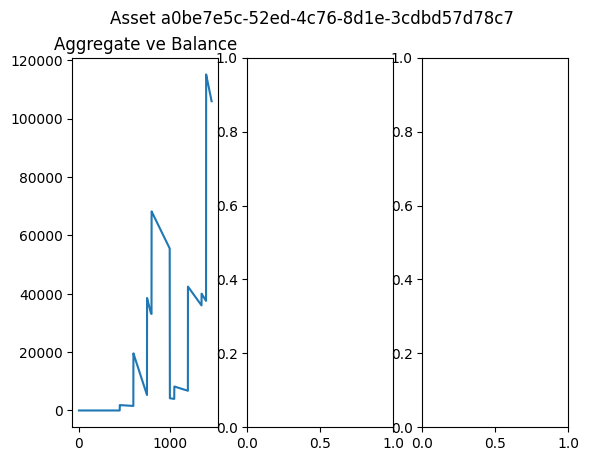

Asset ddc08b4d-1c4a-4b64-af1d-321754fe6aac


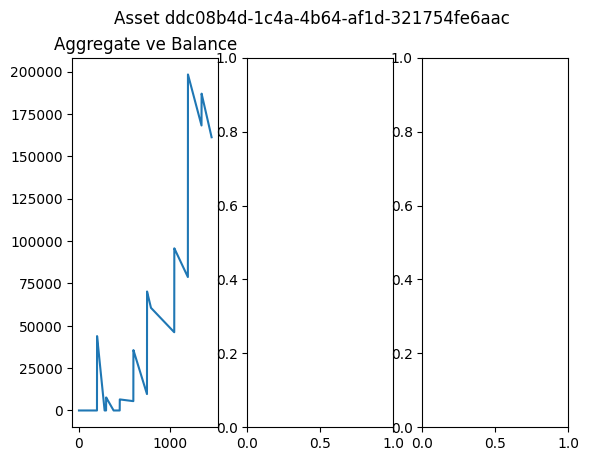

In [7]:
assets_list = []
for i in range(0,max(simulation_result.timestep)):
    for agent in agents_list:
        assets_list.append(simulation_result[simulation_result.substep == 3].agents_oceanholder.iloc[i][agent].votepercent.keys())
assets_list = list(set([item for sublist in assets_list for item in sublist]))

for asset in assets_list:
    print(f"Asset {asset}")
    fig, axs = plt.subplots(1, 3)
    fig.suptitle(f"Asset {asset}")
    axs[0].plot(simulation_result[simulation_result.substep == 3].timestep, simulation_result[simulation_result.substep == 3].agents_data_asset.apply(lambda x: x[asset].veallocation))
    axs[0].set_title('Aggregate ve Balance')
    plt.show()